# Wine Quality and Type Classification


### Introduction
Wine is made through the fermentation of grapes. This fermentation is a result of yeast consuming the sugar within the grapes and then converting it to ethanol, at which point it gets its alcoholic properties. Uderstanding the physiochemical attributes of wine could provide insights into the quality and region that wine originates from. In order to figure out this relationship that exist, we will utilize standard machine learning and data processing techniques. The various models will predict whether the wine sample is red or white. Once its type is categorized its quality will then be determined. 

The dataset is from [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality) and is described below. 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the Vinho Verde website or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

The classes are ordered and not balanced: there are many more normal wines than excellent or poor ones. Outlier detection algorithms will need to be used to detect the few excellent or poor wines. All input variables may not be relevant, feature engineering will be essential to test various selection methods. 


## Uploading Data and Preparing Environment

The data set for can be accessed through the [UCI site](https://archive.ics.uci.edu/ml/datasets/wine+quality).

### Importing Preprocessing and Data Visualization Tools

In [35]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #getting rid of warning from sklearn and seaborn

#Packages
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import Counter
from sklearn.base import TransformerMixin 
%matplotlib inline

Importing the two data frames we will be working with.

In [36]:
red_df = pd.read_csv('data/winequality-red.csv', sep = ';')
white_df = pd.read_csv('data/winequality-white.csv', sep = ';')
#creating a wine_color column to distinguish between type
red_df['wine_color'] = 'red' 
white_df['wine_color'] = 'white' 

In [37]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [38]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


Creating a quality label column based on the score. 

* Bad quality for 5 and below
* Avergae quality for 6 or 7
* high quality for 7 and above

In [39]:
white_df['label'] = white_df['quality'].apply(lambda x: 1 if x <= 5 else 2 if x <= 7 else 3)
red_df['label'] = red_df['quality'].apply(lambda x: 1 if x <= 5 else 2 if x <= 7 else 3)

wine = pd.concat([red_df, white_df], axis = 0) #Combing

#shuffle data for randomization of data points
wine = wine.sample(frac = 1, random_state = 77).reset_index(drop = True)

### Nulls Cleaning

In [40]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_color              0
label                   0
dtype: int64

As you may notice we have zero records with null characteristics, so we won't need to evaluate the option to simply eliminate rows with nulls instead of entering in medians and modes. If the data was missing values we could use the following function to impute the null values depending upon data type.

In [41]:
class null_cleaner(TransformerMixin):

    def __init__(self):
        """
        fills missing values:
        -If the column is dtype object they are imputed with the most frequent
         value within the column
        -The other columns with data types are imputed with the mean
         of the corresponding column
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wine = null_cleaner().fit_transform(wine)

## General Data Description

In [42]:
wine.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


In [43]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_color            6497 non-null   object 
 13  label                 6497 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


In [44]:
Counter(wine['quality'])

Counter({7: 1079, 6: 2836, 5: 2138, 4: 216, 8: 193, 3: 30, 9: 5})

In [45]:
Counter(wine['label'])

Counter({2: 3915, 1: 2384, 3: 198})

## Exploratory Data Analysis

After the null values have been properly dealt with we can evaluate the distribution and spread of the data. We will confirm the inbalances that exist within the classes and figure out possible correlations. 

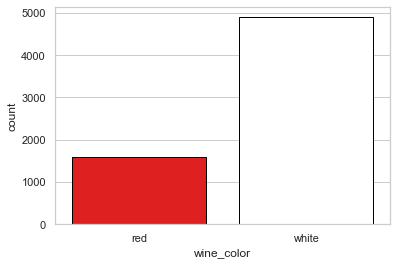

In [46]:
sns.countplot(wine['wine_color'], palette = ['red', 'white'], edgecolor = 'black')
plt.show()

There seems to be a large discrepancy in data counts. We have far more information on white wines than red wines. This imbalance can be dealt with through sorting an inputted wine as either red or white and then assessing its quality label. Let's explore the quality distributions for red and white separately now.

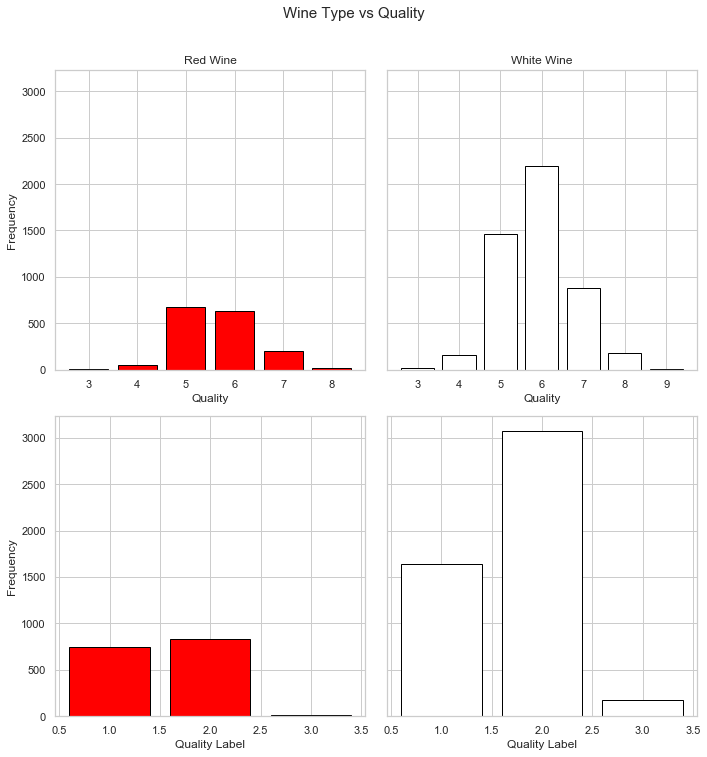

In [47]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize= (10,10), sharey = True)
plt.rc('font', size = 12)
title = fig.suptitle('Wine Type vs Quality', fontsize = 15, y = 1.05)

axes[0, 0].set_title('Red Wine')
axes[0, 0].set_xlabel('Quality')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].bar(list(red_df['quality'].value_counts().index), 
               list(red_df['quality'].value_counts().values),
               color = 'red', edgecolor = 'black')

axes[0, 1].set_title('White Wine')
axes[0, 1].set_xlabel('Quality')
axes[0, 1].bar(list(white_df['quality'].value_counts().index), 
               list(white_df['quality'].value_counts().values),
               color = 'white', edgecolor = 'black')

axes[1, 0].set_xlabel('Quality Label')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].bar(list(red_df['label'].value_counts().index), 
               list(red_df['label'].value_counts().values),
               color = 'red', edgecolor = 'black')

axes[1, 1].set_xlabel('Quality Label')
axes[1, 1].bar(list(white_df['label'].value_counts().index), 
               list(white_df['label'].value_counts().values),
               color = 'white', edgecolor = 'black')

plt.tight_layout()

We have confirmed that there is a large imbalance in data. This is especially apparent between the high quality wines (3.0) and the average quality wines (2.0). 

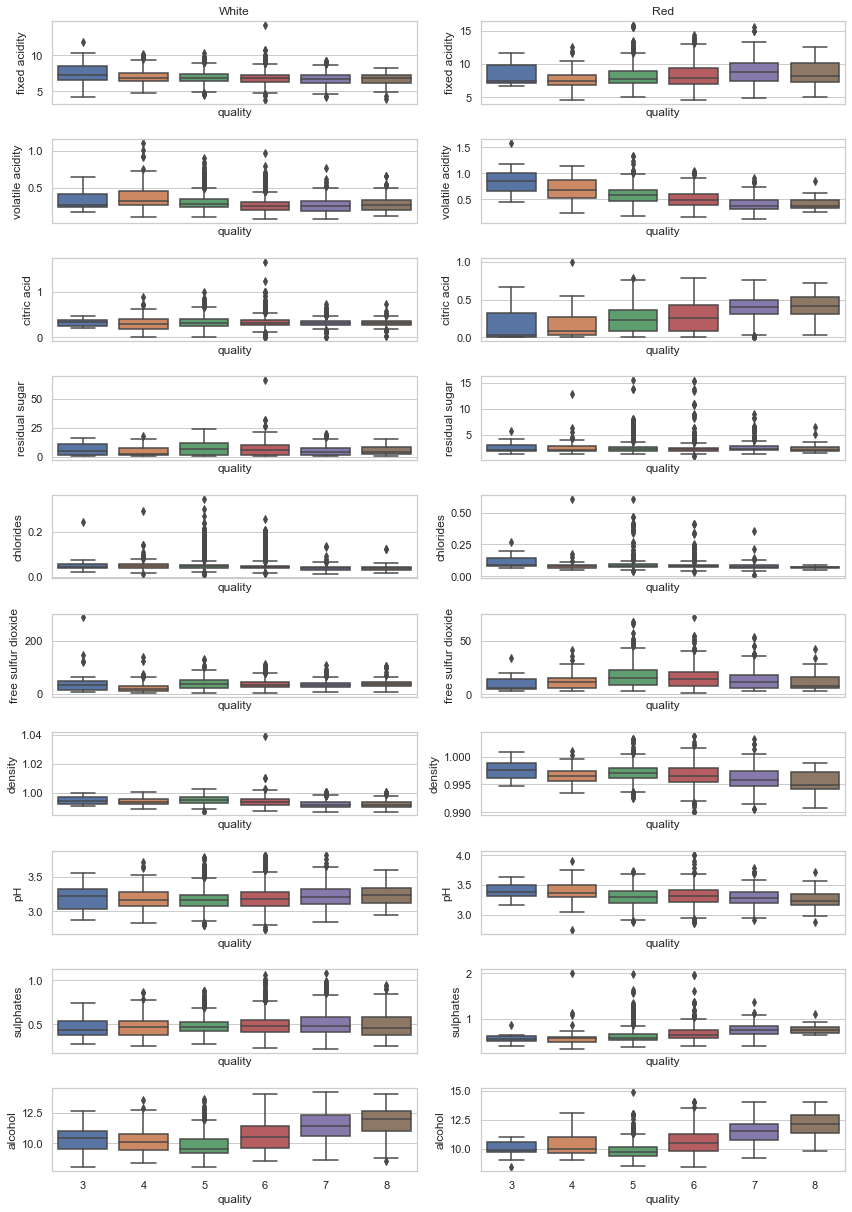

In [48]:
fig, axes = plt.subplots(10, 2, figsize = (12,17), sharex = True)

ax = sns.boxplot(x="quality", y="fixed acidity", data=white_df, orient='v', 
    ax=axes[0, 0])
ax = sns.boxplot(x="quality", y="fixed acidity", data=red_df, orient='v', 
    ax=axes[0, 1])
ax = sns.boxplot(x="quality", y="volatile acidity", data=white_df, orient='v', 
    ax=axes[1, 0])
ax = sns.boxplot(x="quality", y="volatile acidity", data=red_df, orient='v', 
    ax=axes[1, 1])
ax = sns.boxplot(x="quality", y="citric acid", data=white_df, orient='v', 
    ax=axes[2, 0])
ax = sns.boxplot(x="quality", y="citric acid", data=red_df, orient='v', 
    ax=axes[2, 1])
ax = sns.boxplot(x="quality", y="residual sugar", data=white_df, orient='v', 
    ax=axes[3, 0])
ax = sns.boxplot(x="quality", y="residual sugar", data=red_df, orient='v', 
    ax=axes[3, 1])
ax = sns.boxplot(x="quality", y="chlorides", data=white_df, orient='v', 
    ax=axes[4, 0])
ax = sns.boxplot(x="quality", y="chlorides", data=red_df, orient='v', 
    ax=axes[4, 1])
ax = sns.boxplot(x="quality", y="free sulfur dioxide", data=white_df, orient='v', 
    ax=axes[5, 0])
ax = sns.boxplot(x="quality", y="free sulfur dioxide", data=red_df, orient='v', 
    ax=axes[5, 1])
ax = sns.boxplot(x="quality", y="density", data=white_df, orient='v', 
    ax=axes[6, 0])
ax = sns.boxplot(x="quality", y="density", data=red_df, orient='v', 
    ax=axes[6, 1])
ax = sns.boxplot(x="quality", y="pH", data=white_df, orient='v', 
    ax=axes[7, 0])
ax = sns.boxplot(x="quality", y="pH", data=red_df, orient='v', 
    ax=axes[7, 1])
ax = sns.boxplot(x="quality", y="sulphates", data=white_df, orient='v', 
    ax=axes[8, 0])
ax = sns.boxplot(x="quality", y="sulphates", data=red_df, orient='v', 
    ax=axes[8, 1])
ax = sns.boxplot(x="quality", y="alcohol", data=white_df, orient='v', 
    ax=axes[9, 0])
ax = sns.boxplot(x="quality", y="alcohol", data=red_df, orient='v', 
    ax=axes[9, 1])

axes[0,0].title.set_text('White')
axes[0,1].title.set_text('Red')
plt.tight_layout()

The boxplots show outliers for quite a few columns. Fixed acidity for red wine has a first quartile value of 7.1 with its second quartile value being 7.9. Not much of a variance which explains the huge number of outliers. White wines fixed acidity has a first quartile value of 6.3 and second quartile value of 6.8, again not much variance. Similar logic applies for volatile acidity for both types of wine. The Citric acid column seems to be uniformly distributed. The other columns red (white) are described below. Residual sugar has a minimum of 0.9 (0.6) but a maximum of 15.5 (65.8), far too much difference. Chlorides also have a huge difference with their minimum value being 0.012 (0.009) and the maximum being 0.61 (0.35). This is the case for free sulfur dioxide as well, minimum is 1 (2.0) and maximum is 72 (289).

 ## Wine Attributes and Properties

It is important to understand the attributes and properties when it comes to running models and performing proper data diagnostics. 

#### Acidity

Acids are an essential attribute that contribute the taste of a wine. Acidity in food and drinks tastes tart and zesty. The taste acidity is also sometimes confused with alcohol. Wines with higher acidity will feel lighter-bodied to the palette and come across as 'spritzy'. A large reduction in acid will cause the wines to taste flat. Less acidity is associated with a more round and rich taste. 

***Acidity Characteristics***
* Tingling sensation that focuses on the front and sides of your tongue.
* A gravelly filament on the side and roof of your mouth.
* A Wet or cold sensation similar to eating a green apple.
* Your mouth has a sensation to produce more saliva.

***Acid Types and Measures***

* **Fixed Acidity**: The fixed acids include malic, citric, succinic, and tartaric acids. These are all found in the grapes of the wine, except for succinic acid. The data set includes this measure in units of $\frac{g(tartaricacid)}{dm^3}$.
* **Citric Acid**: This is one of the fixed acids. It is associated with wines. Most of this acid is consumed during the fermentation process and is occasionally added afterwards to make the wine feel 'new'. The data set measures citric acid in units of $\frac{g}{dm^3}$.
* **Volatile Acidity**: These acids are distilled from wine before the production process. Volatile acids include lactic, formic, and butyric acids. An excess of volatile acids will lead to undesirable flavors that usually resemble an upleasant bitterness. The legal limit of volatile acids in the United States is 1.2 g/L for red wine and 1.1 g/L for white wine. In this data set volatile acidity is expressed in units of $\frac{g(aceticacid)}{dm^3}$. 
* **pH**: pH stands for the potential of hydrogen. It is a scale commonly used to express a compounds acidity or basicity. The fixed acidity contributed the most towards pH of wines. Solutions with a pH less than 7 are acidic, while solutions with a pH greater than 7 are basic. Pure water is neutral on this scale at 7. Most wines are between a pH of 2.9 and 3.9. This classifies wine as acidic.

#### Sweetness

How sweet is the wine? When it hits are palette do we find it familiar to a piece of candy or is it more sour? The human perception of sweet begins at the tip of the tongue. Wine is usually the most direct impression when first tasting a wine. Wine connoisseurs focus on the tip of their tongue when measuring sweetness. The sweetness can tingle your taste buds and cause salivation. Dry wines often still have some level of sweetness in order to make it more full-bodies (as a fancy wine connoisseur might say). 

***Sweetness Characteristics***
* Tingling sensation towards the tip of your tongue
* The wine is thicker with a higher level of viscosity; the wine tears fall slower.
* An oily filament on the middle of your tongue that lingers.
* Dry reds often contain higher residual sugar than expected.

***Sweetness Types and Measures***
* **Residual Sugar**: This refers to the sugar found within grapes after fermentation, which is why its refered to as residual. This data was measured in $\frac{g}{dm^3}$.


#### Salty
Salt content is not typicall used as wine descriptor. If you're like me, when you think of wine characteristics salt is one of the last things that comes to mind. Wine producing countries commonly have legal maximums for sodium chloride content. The salinity of a wine is usually determined by the soil the grapes grow in. Dryer regions often suffer from saltier wines because of irrigation systems that increase soil salinity. Most characteristics of soil don't translate to grape composition but salt is the exception. 

***Salty Characteristics***
* Salt often isn't found in wines because it is not a sought after but when it is imagine pouring some wine on a saltine and you'll have a similar experience.

***Salty Types and Measures***
* **Chlorides**: The chloride concentration in wine is a result of the terriot and comes from regions with high irrigation. This quality is expressed in units of $\frac{g(sodiumchloride)}{dm^3}$.

#### Sulfites

Sulfites in wine refer to the naturally occuring chemical compounds. Sulfur dioxide is naturally found in wines and is a byproduct of fermentation, but most winemakers choose to add a little extra to prevent growth of undesirable yeast and microbes, as well as to protect against oxidation. 

***Sulfite Characteristics***

* Wines with a lower acidity will need more sulfites than higher acidity wines. A wine with a pH of 3.6 and above are much less stable and in order to preserve shelf-life more sulfites are needed.
* White wines typically need more sulfites because of the shorter length of their fermentation. A typical dry white wine may have around 100 mg/L whereas a typical dry red wine will have around half of that. 
* A higher sugar content could lead to further fermentation so more sulfites will be required to prevent this.
* Wines that need less temperature to be preserved tend to release free sulfur compounds. This can be fixed through decantation or chilling the wines. 

***Sulfite Types and Measures***

* **Sulphates**:These are mineral salts that contain sulfur. Sulphates have a relationship with wine that is simmilar to gluten in food. They are a regular part of the winemaking procedure and are considered essential. These sulphates are connected to the fermentation process and drastically effect the wines aroma and flavor. The data expresses sulphates in units of $\frac{g(potassiumsulphate)}{dm^3}$. 
* **Free Sulfur Dioxide**: This is the free sulfur dioxide that when added to wine after the remaining part binds. Winemakers continuously try to get this free sulfur to bind since too much of it is considered undesirable. An abundance of these free sulphites results in a rotten egg kind of odor. This column is measured in units of $\frac{mg}{dm^3}$.
* **Total Sulfur Dioxide**: As indicated by the name, this is the total amount of bound and free sulfite. This is still expressed in units of $\frac{mg}{dm^3}$. More sulfur is typically added to kill additional bacteria and preserve freshness. There are usually legal limits for the amount of sulfur that can be within wine. 

#### Alcohol

I am sure we are all well acquainted with alcohol. Alcohol is formed as a result of yeast converting sugar during the fermentation process. The percentage of alcohol can vary from wine to wine. There are a variety of different taste receptors that sense alcohol. This is white alcohol can taste bitter, sweet, or even spicy. Genetics tend to play a huge role in the number of taste receptors are activated. The warming sensation in the back of the throat is attributed to the amount of alcohol within the wine. 

***Alcohol Characteristics***
* A wine with higher alcohol content can taste oily and bolder while wines with less alcohol tend to taste lighter. 

***Alcohol Types and Measures***
* Alcohol: There is usually one metric to measure alcohol. It is typically measured as percent volume or alcohol by volume.

#### Body
This is often a misunderstood identifier outside of the wine world. The body of a wine is commonly described as light, medium, or full bodied and is a result of many factors. It depends on wine variety, origin, or the alcohol level of the wine. The body is used as a general impression of the wine. 

***Body Characteristics***
* Red wines are typically more full bodied than whites. 
* A wine that is said to be full bodied often has a variety of flavors and evolves as it rest on your palette. 

***Body Types and Measures***
* **Density**: This is measured as relative density. Relative density usually refers to the weight of wine relative to an equivalent volume of water. It can also be used a measure of the conversion of sugar to alcohol. In this data set the units for density is $\frac{g}{cm^3}$.

#### Classifications
These are the values we will be attempting to predict through our models as well as examine the correlations between them and the other parameters. 
* **Wine Color/Type**: We concatenated two data sets into one called 'wine'. These two data sets were composed of red and white wines. Upon the concatenation we created a new column called 'color' that labeled the wine as either or red or wine so that information wouldn't be lost. A wine can either be a 'red' or 'white' wine.
* **Quality**: A variety of wine experts graded each wine from 0 (horrible) to 10 (incredible). The quality score is the median of at least three evaluations.
* **Quality Label**: We then manually organized the data into three labels of 1, 2, and 3. The bins were created in order to try and offset some of the data inbalance. The quality label of 1 is associated with a quality score of 1, 2, 3, 4, or 5. A quality label of 2 is associated with a quality score of 6 or 7. A quality label of 3 is associated with a quality score of 8, 9, or 10.

## Statistical Descriptions

Let's view the statistical components and correlations of our data set for red and white wines.  

In [49]:
pd.concat([red_df.describe().T, white_df.describe().T], axis = 1, keys = ['Red Wine Statistical Description','White Wine Statistical Description'])

Red Wine Statistical Description                        \
                                                count       mean        std   
fixed acidity                                  1599.0   8.319637   1.741096   
volatile acidity                               1599.0   0.527821   0.179060   
citric acid                                    1599.0   0.270976   0.194801   
residual sugar                                 1599.0   2.538806   1.409928   
chlorides                                      1599.0   0.087467   0.047065   
free sulfur dioxide                            1599.0  15.874922  10.460157   
total sulfur dioxide                           1599.0  46.467792  32.895324   
density                                        1599.0   0.996747   0.001887   
pH                                             1599.0   3.311113   0.154386   
sulphates                                      1599.0   0.658149   0.169507   
alcohol                                        1599.0  10.422983   1.065668   
quality                                        1599.0   5.636023   0.807569   
label                                          1599.0   1.545966   0.520164   

                                                                        \
                          min      25%       50%        75%        max   
fixed acidity         4.60000   7.1000   7.90000   9.200000   15.90000   
volatile acidity      0.12000   0.3900   0.52000   0.640000    1.58000   
citric acid           0.00000   0.0900   0.26000   0.420000    1.00000   
residual sugar        0.90000   1.9000   2.20000   2.600000   15.50000   
chlorides             0.01200   0.0700   0.07900   0.090000    0.61100   
free sulfur dioxide   1.00000   7.0000  14.00000  21.000000   72.00000   
total sulfur dioxide  6.00000  22.0000  38.00000  62.000000  289.00000   
density               0.99007   0.9956   0.99675   0.997835    1.00369   
pH                    2.74000   3.2100   3.31000   3.400000    4.01000   
sulphates             0.33000   0.5500   0.62000   0.730000    2.00000   
alcohol               8.40000   9.5000  10.20000  11.100000   14.90000   
quality               3.00000   5.0000   6.00000   6.000000    8.00000   
label                 1.00000   1.0000   2.00000   2.000000    3.00000   

                     White Wine Statistical Description              \
                                                  count        mean   
fixed acidity                                    4898.0    6.854788   
volatile acidity                                 4898.0    0.278241   
citric acid                                      4898.0    0.334192   
residual sugar                                   4898.0    6.391415   
chlorides                                        4898.0    0.045772   
free sulfur dioxide                              4898.0   35.308085   
total sulfur dioxide                             4898.0  138.360657   
density                                          4898.0    0.994027   
pH                                               4898.0    3.188267   
sulphates                                        4898.0    0.489847   
alcohol                                          4898.0   10.514267   
quality                                          4898.0    5.877909   
label                                            4898.0    1.701919   

                                                                           \
                            std      min         25%        50%       75%   
fixed acidity          0.843868  3.80000    6.300000    6.80000    7.3000   
volatile acidity       0.100795  0.08000    0.210000    0.26000    0.3200   
citric acid            0.121020  0.00000    0.270000    0.32000    0.3900   
residual sugar         5.072058  0.60000    1.700000    5.20000    9.9000   
chlorides              0.021848  0.00900    0.036000    0.04300    0.0500   
free sulfur dioxide   17.007137  2.00000   23.000000   34.00000   46.0000   
total sulfur dioxide  42.498065  9.00000  

In general white wines tend to have a higher sugar content then red wines, which is apparent by the mean of the residual sugar for red and white wines. The total sulfur dioxide and citric acids seems to have a larger presence in white wines compared to reds. Reds on the other hand have a higher sulphate, fixed acidity, and volatile acidity content then white wines. 

Lets now examine the differences in general statistics for quality.

In [50]:
bad_q = wine[wine['label'] == 1].describe()
avg_q = wine[wine['label'] == 2].describe()
high_q = wine[wine['label'] == 3].describe()
pd.concat([bad_q, avg_q, high_q], axis = 0, keys = ['Bad Quality Wine', 'Average Quality Wine', 'High Quality Wine'])

fixed acidity  volatile acidity  citric acid  \
Bad Quality Wine     count    2384.000000       2384.000000  2384.000000   
                     mean        7.329992          0.397410     0.304178   
                     std         1.268400          0.187971     0.162936   
                     min         4.200000          0.100000     0.000000   
                     25%         6.500000          0.260000     0.210000   
                     50%         7.100000          0.337500     0.295000   
                     75%         7.800000          0.500000     0.400000   
                     max        15.900000          1.580000     1.000000   
Average Quality Wine count    3915.000000       3915.000000  3915.000000   
                     mean        7.163946          0.306955     0.326664   
                     std         1.313999          0.139826     0.134743   
                     min         3.800000          0.080000     0.000000   
                     25%         6.400000          0.210000     0.260000   
                     50%         6.900000          0.270000     0.310000   
                     75%         7.600000          0.360000     0.390000   
                     max        15.600000          1.040000     1.660000   
High Quality Wine    count     198.000000        198.000000   198.000000   
                     mean        6.850000          0.291187     0.333889   
                     std         1.144918          0.118123     0.102157   
                     min         3.900000          0.120000     0.030000   
                     25%         6.200000          0.210000     0.280000   
                     50%         6.800000          0.275000     0.320000   
                     75%         7.300000          0.350000     0.367500   
                     max        12.600000          0.850000     0.740000   

                            residual sugar    chlorides  free sulfur dioxide  \
Bad Quality Wine     count     2384.000000  2384.000000          2384.000000   
                     mean         5.646225     0.064404            29.480495   
                     std          4.917239     0.042812            19.844383   
                     min          0.600000     0.009000             2.000000   
                     25%          1.800000     0.043000            14.000000   
                     50%          2.900000     0.052000            26.000000   
                     75%          8.525000     0.077000            42.000000   
                     max         23.500000     0.611000           289.000000   
Average Quality Wine count     3915.000000  3915.000000          3915.000000   
                     mean         5.324291     0.051709            30.960281   
                     std          4.683706     0.028906            16.332851   
                     min          0.700000     0.012000             1.000000   
                     25%          1.800000     0.036000            19.000000   
                     50%          3.000000     0.045000            29.000000   
                     75%          7.900000     0.058000            41.000000   
                     max         65.800000     0.415000           112.000000   
High Quality Wine    count      198.000000   198.000000           198.000000   
                     mean         5.351010     0.040778            34.505051   
                     std          4.161541     0.015679            17.084070   
                     min          0.800000     0.014000             3.000000   
                     25%          2.000000     0.030250            24.000000   
                     50%          4.050000     0.036500            34.000000   
                     75%          7.575000     0.045000            43.000000   
                     max         14.800000     0.121000           105.000000   

                            total sulfur dioxide      density           pH  \
Bad Quality Wine     count           2384.000000

It is interesting how the alcohol content doesn't give much variation to see if the wine is either red or white, yet it makes a large difference in quality. It seems to be that the higher the average alcohol concentration the better the quality. However, lower quality wines have the lowest standard deviation. 

There is less chlorides and volatile acidity with a smaller standard deviation in higher quality of wines.

Sulfur dioxide increase with quality as well, but the standard deviation decreases with an increase in quality.

Higher quality wines also has less of a fixed acidity, but the standard deviation is slighlty higher in mean quality. 

### Inferential Statistics

The general notion of inferential statistics is to draw inferences and propositions of a population using a data sample. The idea is to use statistical methods and models to draw statistical inferences from a given hypotheses. Each hypothesis consists of a null hypothesis and an alternative hypothesis. Based on statistical test results, if the result is statistically significant based on pre-set significance levels (e.g., if obtained p-value is less than 5% significance level), we reject the null hypothesis in favor of the alternative hypothesis. Otherwise, if the results is not statistically significant, we conclude that our null hypothesis was correct.

A great statistical model to prove or disprove the difference in mean among subsets of data is to use the one-way ANOVA test. ANOVA stands for “analysis of variance,” which is a nifty statistical model and can be used to analyze statistically significant differences among means or averages of various groups. This is basically achieved using a statistical test that helps us determine whether or not the means of several groups are equal. 

The alternative hypotheses, H<sub>A</sub>, tells us that there exists at least two group means that are statistically significantly different from each other. Usually the F-statistic and the associated p-value from it is used to determine the statistical significance. Typically a p-value less than 0.05 is taken to be a statistically significant result where we reject the null hypothesis in favor of the original. 

So let's evaluate the hypotheses of each of our previous highlights through the statistical inference test

In [51]:
def type_h_testing(feature):
    F, p = f_oneway(red_df[feature],
                    white_df[feature])
    if p <= 0.05: # Standard Measure 
        result = 'Reject'
    else:
        result = 'Accept'
    print('ANOVA test for {}:'.format(feature))
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothese: {}'.format(F, p, result))
    
def quality_h_testing(feature):
    F, p = f_oneway(wine[wine['label'] == 1][feature],
                    wine[wine['label'] == 2][feature],
                    wine[wine['label'] == 3][feature])
    if p <= 0.05:
        result = 'Reject'
    else:
        result = 'Accept'
    print('ANOVA test for {}:'.format(feature))
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, result))

In [52]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color,label
0,6.8,0.36,0.32,1.80,0.067,4.0,8.0,0.99280,3.36,0.55,12.8,7,red,2
1,8.3,0.20,0.74,4.45,0.044,33.0,130.0,0.99240,3.25,0.42,12.2,6,white,2
2,7.2,0.16,0.32,0.80,0.040,50.0,121.0,0.99220,3.27,0.33,10.0,6,white,2
3,6.6,0.58,0.00,2.20,0.100,50.0,63.0,0.99544,3.59,0.68,11.4,6,red,2
4,6.2,0.35,0.31,2.60,0.036,37.0,92.0,0.98938,3.27,0.53,12.8,7,white,2


In [53]:
print('Anova Test for Types of Wine \n')
for column in wine.drop(['wine_color', 'label', 'quality'], axis = 1).columns:
    type_h_testing(column)

Anova Test for Types of Wine 

ANOVA test for fixed acidity:
F Statistic: 2016.51 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for volatile acidity:
F Statistic: 4829.32 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for citric acid:
F Statistic: 236.39 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for residual sugar:
F Statistic: 899.77 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for chlorides:
F Statistic: 2315.83 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for free sulfur dioxide:
F Statistic: 1858.14 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for total sulfur dioxide:
F Statistic: 6252.80 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for density:
F Statistic: 1169.66 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for pH:
F Statistic: 789.05 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for sulphates:
F Statistic: 2021.71 	p-value: 0.000 	Null Hypothese: Reject
ANOVA test for alcohol:
F Statistic: 7.07 	p-value: 0.008 	Null Hypothes

In [54]:
print('Anova Test for Types of Wine \n')
for column in wine.drop(['wine_color', 'label', 'quality'], axis = 1).columns:
    quality_h_testing(column)

Anova Test for Types of Wine 

ANOVA test for fixed acidity:
F Statistic: 20.38 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for volatile acidity:
F Statistic: 250.34 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for citric acid:
F Statistic: 18.97 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for residual sugar:
F Statistic: 3.43 	p-value: 0.032 	Null Hypothesis: Reject
ANOVA test for chlorides:
F Statistic: 120.96 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for free sulfur dioxide:
F Statistic: 10.31 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for total sulfur dioxide:
F Statistic: 7.84 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for density:
F Statistic: 287.59 	p-value: 0.000 	Null Hypothesis: Reject
ANOVA test for pH:
F Statistic: 1.24 	p-value: 0.291 	Null Hypothesis: Accept
ANOVA test for sulphates:
F Statistic: 6.88 	p-value: 0.001 	Null Hypothesis: Reject
ANOVA test for alcohol:
F Statistic: 673.07 	p-value: 0.000 	Null Hypothesis: Re

### Correlation

To examine the linear relationship that exist between features we will check the correlations and create a heat map for better visualization. 

A correlation matric is identical to a covariance matrix that is computed from standardized data. The correlation matrix is a square matrix that contrains the Pearson product-moment correlation coefficients (often abbreviated as [Pearson's r](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)), which measure the linear dependence between pairs of features:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/602e9087d7a3c4de443b86c734d7434ae12890bc)

Pearson's correlation coefficient can simply be calculated as the covariance between two features x and y (numerator) divided by the product of their standard deviations (denominator):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec)

The covariance between standardized features is in fact equal to their linear correlation coefficient.
Use NumPy's corrcoef and seaborn's heatmap functions to plot the correlation matrix array as a heat map.

To fit a linear regression model, we are interested in those features that have a high correlation with our target variable. So, let's prepare the dataset and the type and quality label targets variables. 

In [55]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color,label
0,6.8,0.36,0.32,1.80,0.067,4.0,8.0,0.99280,3.36,0.55,12.8,7,red,2
1,8.3,0.20,0.74,4.45,0.044,33.0,130.0,0.99240,3.25,0.42,12.2,6,white,2
2,7.2,0.16,0.32,0.80,0.040,50.0,121.0,0.99220,3.27,0.33,10.0,6,white,2
3,6.6,0.58,0.00,2.20,0.100,50.0,63.0,0.99544,3.59,0.68,11.4,6,red,2
4,6.2,0.35,0.31,2.60,0.036,37.0,92.0,0.98938,3.27,0.53,12.8,7,white,2


In [56]:
# re-shuffle data to randomize data points
wine = wine.sample(frac = 1, random_state = 77).reset_index(drop = True)
type_encoder = LabelEncoder()
wine['wine_color'] = type_encoder.fit_transform(wine['wine_color'].values)
# 'white': 1, 'red': 0

Now we can check for correlations based on wine types.

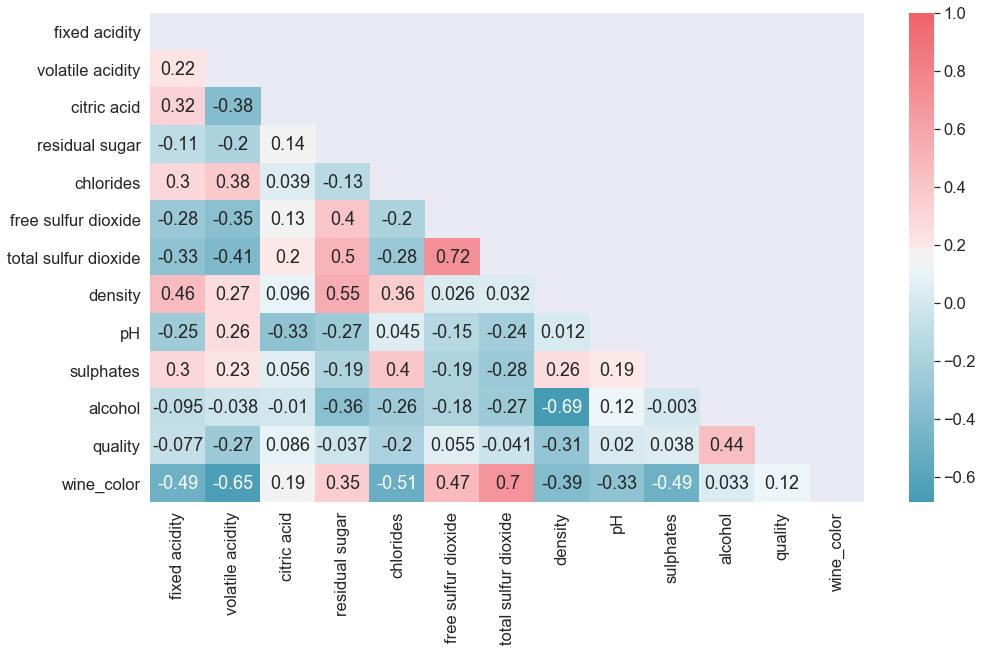

In [57]:
sns.set(font_scale=1.5)
corr = wine.corr().drop('label', axis = 1)
type_sorted = corr.sort_values('wine_color', ascending = False).keys()
corr_matrix = corr.loc[type_sorted, type_sorted] #sorts columns
mask = np.zeros_like(corr_matrix, dtype = np.bool) 
mask[np.triu_indices_from(mask)] = True #mask for heatmap
plt.figure(figsize = (16, 9))
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(h_neg = 220, h_pos = 10, s = 80, l = 60, as_cmap = True),
            annot = True, mask = mask)

plt.show()

A good portion of the correlations seem to be weak, but there are some important observations:

* Total and free sulfur dioxide has the highest correlation with white wines and each other. In fact, the second is a parcel of the first and represents a colinearity that can be a problem for linear classifiers, especially if the target will predict the color, in that case we need to drop the free sulfur dioxide.
* The residual sugar has a 0.50 relation to the total sulfur dioxide and 0.40 with fre sulfur dioxide, it is a god indication that wich more residual sugar more sulfur dioxide is added by the winemaker. The 0.50 indicates that white wine tends to have higher residual sugar than red wine.
* The density also has a relatively high positive correlation to residual sugar (0.55) and relatively high negative correlation to alcohol (-0.69).
* The chlorides and volatile acidity has -0.51 and -0,65 correlations between color, indicating a correlation that can assist in wine color classification.

Let's explore a graphical representation of the relationship between the features using pair plots. 

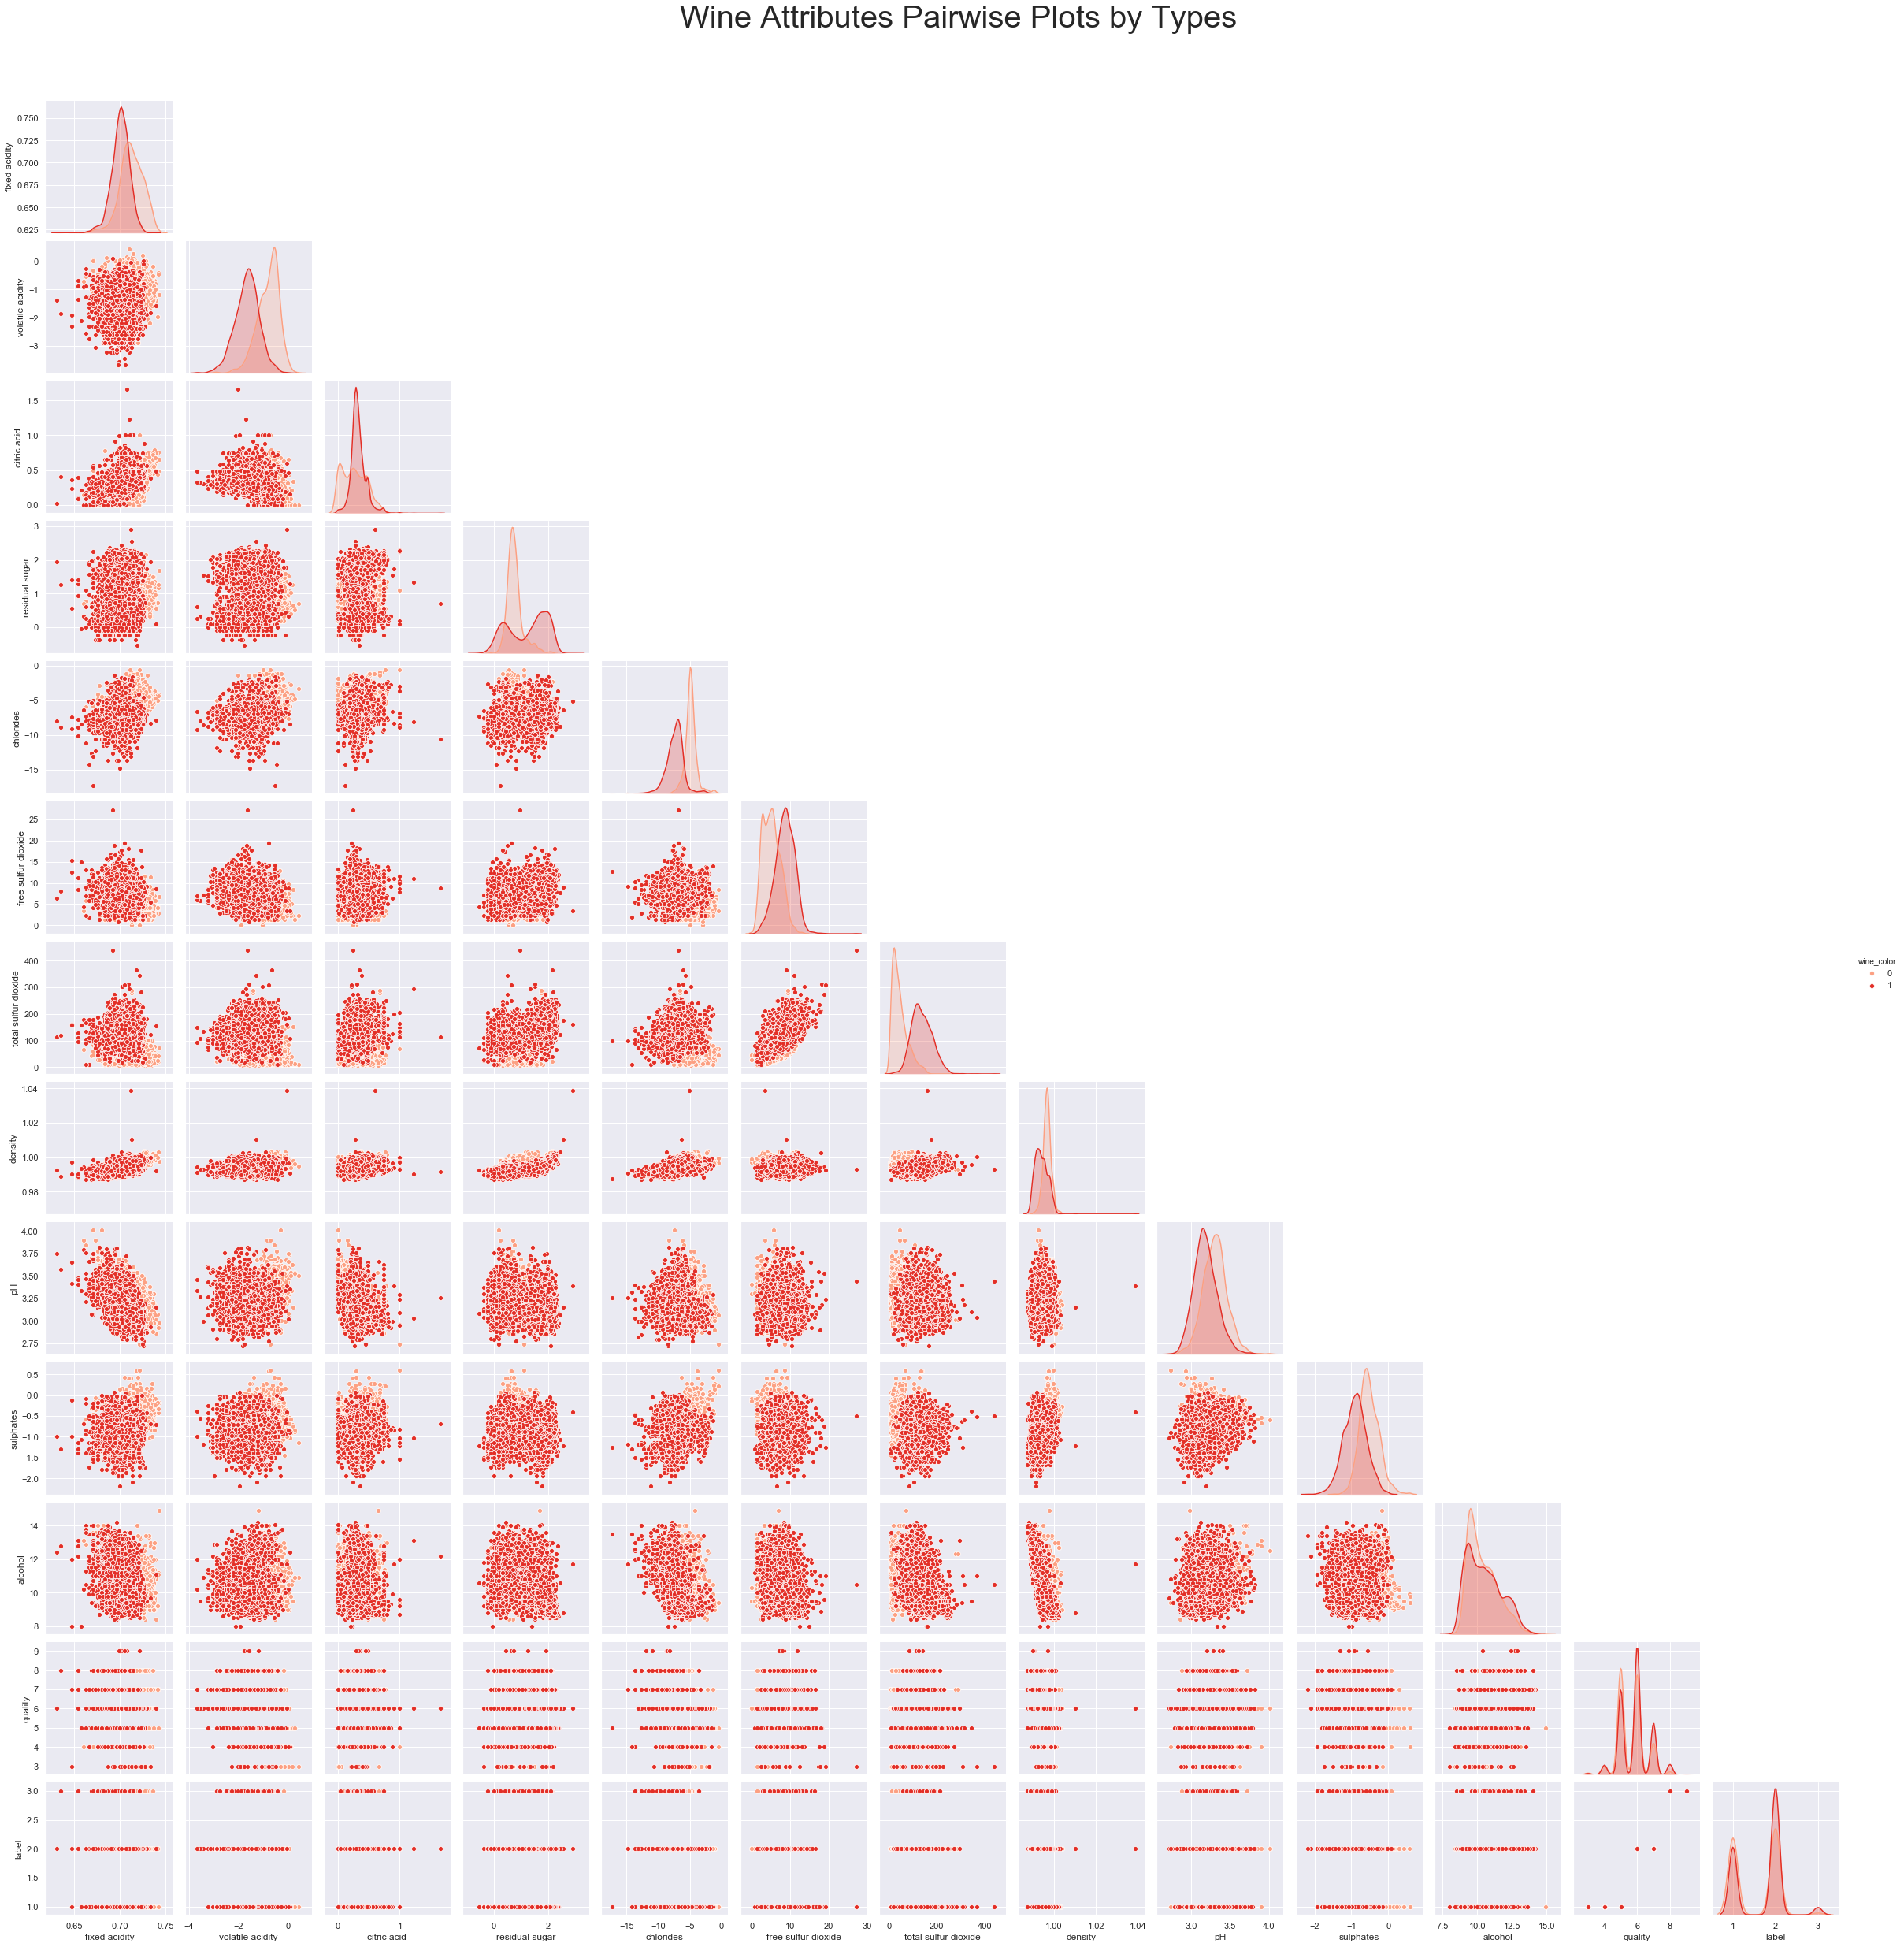

In [68]:
g = sns.pairplot(data = wine, hue = 'wine_color', 
                 palette = 'Reds')

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

fig = g.fig
fig.suptitle('Wine Attributes Pairwise Plots by Types', fontsize = 40, y = 1.05)

plt.show()

from the pair plot we notice several patterns and correlations. These observations are in alignment with the insights we obtained from the ANOVA test and our presumptions regarding correlations. 

* The residual sugar, total sulfur dioxide, and citric acid in white wine seems to be much higher than in red wines. 
* Sulphates, fixed acidity, and volatile acidity seem to be higher in red wine than in white wine. 
* There seems to be a negative correlation between density and alcohol. This is confirmed by the linear trend of the points from left to right in a sharply decreasing direction. 
* Density also seems to have a positive correlation with residual sugar, which is slightly reinforced by the outliers. 

Let's examine the correlation depending upon wine quality.

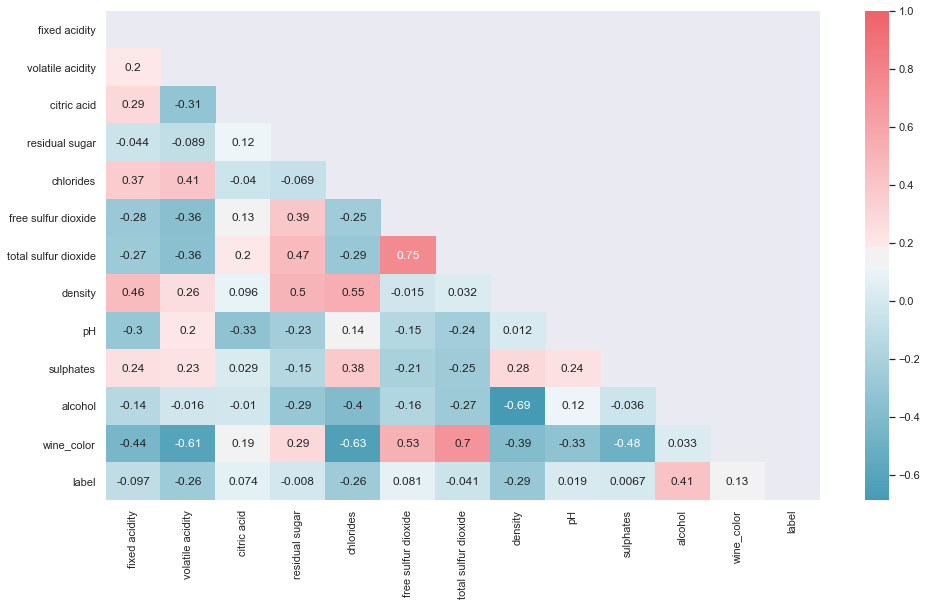

In [69]:
corr = wine.corr().drop('quality', axis = 1)
sort_ql = corr.sort_values('label', ascending = False).keys()
corr_matrix = corr.loc[sort_ql, sort_ql]
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (16, 9))
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(h_neg = 220, h_pos = 10, s = 80, l =60, as_cmap = True),
            annot = True, mask = mask)

plt.show()

This is in alignment with the insights we gained form the ANOVA test and correlations we looked at earlier. 

* Once again the higher quality wines seem to have lower sulphate levels. However, the highest sulphate values are found in the medium quality wines. 
* Lower levels of volatile acid seem to correspond with higher quality labels.
* The highest correlation is 0.72, which is between free sulfur dioxide and total sulfur dioxide. This is the same correlation we picked on in the previous pair plot.

It might be beneficial to take a closer look at the box plots for the alcohol content depending upon quality.

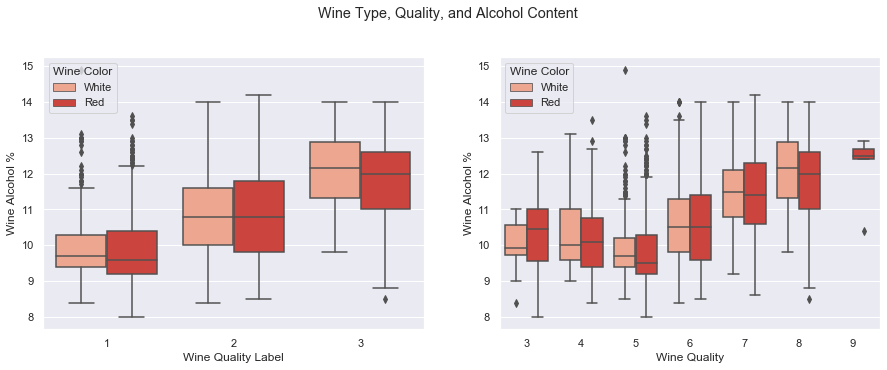

In [70]:
sns.set(font_scale = 1)
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('Wine Type, Quality, and Alcohol Content', y = 1.02)

sns.boxplot(x = 'label', y = 'alcohol', data = wine, 
            hue = 'wine_color', palette = 'Reds', ax = axes[0])
h, l = axes[0].get_legend_handles_labels()
axes[0].set_xlabel("Wine Quality Label")
axes[0].set_ylabel("Wine Alcohol %")
axes[0].legend(h, ['White', 'Red'], title = 'Wine Color')


sns.boxplot(x = 'quality', y = 'alcohol', data = wine, 
            hue = 'wine_color', palette = 'Reds', ax = axes[1])
h2, l2 = axes[1].get_legend_handles_labels()
axes[1].legend(h2, ['White', 'Red'], title = 'Wine Color')
axes[1].set_xlabel("Wine Quality")
axes[1].set_ylabel("Wine Alcohol %")

plt.show()

Each box plot depicts the distribution of alcohol level for a particular wine quality rating that is seperated by wine types. We can see that the wine alcohol by volume distribution has an increasing trend based on higher quality rated wine samples. There are some outliers in each quality level, which is often depicted by individual points. 

Now lets take a closer look at the box plots for wine types, quality, and acidity.

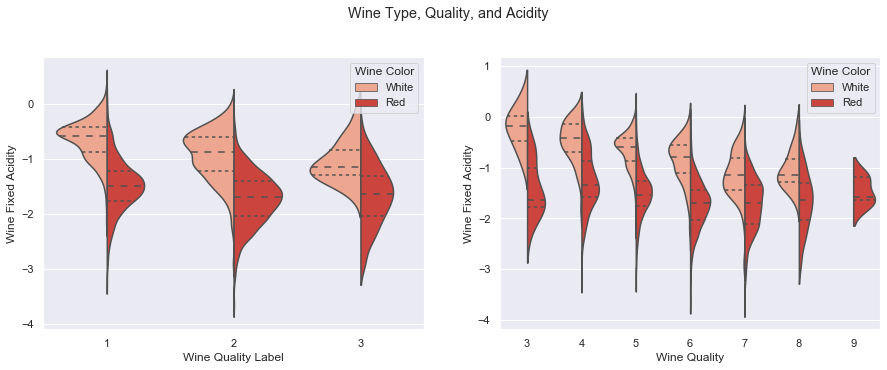

In [71]:
f, axes = plt.subplots(1, 2, figsize = (15, 5))
f.suptitle('Wine Type, Quality, and Acidity', y = 1.02)

sns.violinplot(x = 'label', y = 'volatile acidity', data = wine, 
               hue = 'wine_color', palette = 'Reds', ax = axes[0],
               split = True,  inner = 'quart')
h, l = axes[0].get_legend_handles_labels()
axes[0].set_xlabel('Wine Quality Label')
axes[0].set_ylabel('Wine Fixed Acidity')
axes[0].legend(h, ['White', 'Red'], title = 'Wine Color')

sns.violinplot(x = 'quality', y = 'volatile acidity', data = wine, 
               hue = 'wine_color', palette = 'Reds', ax = axes[1], 
               split = True, inner = 'quart')
h2, l2 = axes[1].get_legend_handles_labels()
axes[1].set_xlabel('Wine Quality')
axes[1].set_ylabel('Wine Fixed Acidity')
axes[1].legend(h, ['White', 'Red'], title = 'Wine Color')

plt.show()

Looking at each side of the violin plot it is very evident that red wines tend to have a lower fixed acidity than white wines. There also seems to be an overall decrease in acidity as quality increases, especially for white wines. 

Let's examine some other parameters in closer detail.

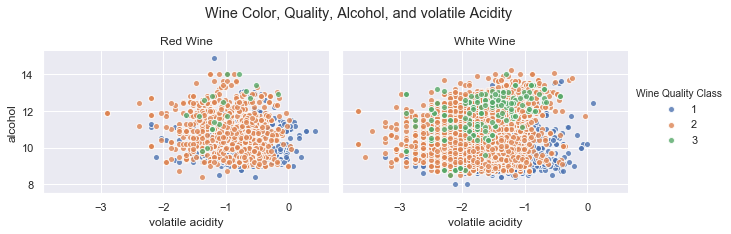

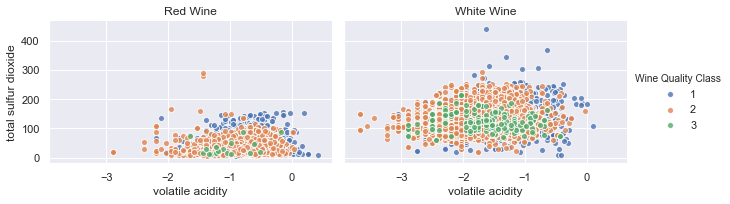

In [72]:
g = sns.FacetGrid(wine, col = 'wine_color', hue = 'label', aspect = 1.5)
g = g.map(plt.scatter, 'volatile acidity', 'alcohol' ,alpha = 0.8,
          edgecolor = 'white')
axes = g.axes.flatten()
axes[0].set_title('Red Wine')
axes[1].set_title('White Wine')
fig = g.fig
fig.suptitle('Wine Color, Quality, Alcohol, and volatile Acidity', y = 1.08)
l = g.add_legend(title = 'Wine Quality Class')


g = sns.FacetGrid(wine, col = 'wine_color', hue = 'label', aspect = 1.5)
g = g.map(plt.scatter, 'volatile acidity', 'total sulfur dioxide',
          edgecolor = 'white', alpha = 0.8)
axes = g.axes.flatten()
axes[0].set_title('Red Wine')
axes[1].set_title('White Wine')
l = g.add_legend(title = 'Wine Quality Class')


There seems to be a pattern depicting slightly higher sulphate levels for higher quality rated wine samples. It seems to be clear that sulphate levels for red wines are much higher as compared to the white wines. 

From the first pair of graphs we see that higher quality wine samples tend to have a lower level of volatile acidity but higher levels of alcohol content when compared to lower rated wines. In general the volatile acidity is marginally lower in white wines compared to red wines. 

The volatile acid and total sulfur dioxide are considerably lower in high quality wine samples. Volatile acidity levels are slightly lower in white wine samples opposed to red wine samples. 

## Data Engineering

We need to perform a bit more cleaning, transformation, selection, and reduction in order for our data to be ready to sample. 

#### Box Cox Transformation

A box cox transformation turn data that is not normally distributed and puts into a normal shape. This is done for two reasons:

- **Model bias and spurious interactions**: If you are performing a regression or any statistical modeling, this asymmetrical behavior may lead to a bias in the model. If a factor has a significant effect on the average, because the variability is much larger, many factors will seem to have a stronger effect when the mean is larger. This is not due, however, to a true factor effect but rather to an increased amount of variability that affects all factor effect estimates when the mean gets larger. This will probably generate spurious interactions due to a non-constant variation, resulting in a **very complex model** with many **spurious** and **unrealistic** interactions.
- **Normality is an important assumption for many statistical techniques**: such as individuals control charts, Cp/Cpk analysis, t-tests and analysis of variance (ANOVA). A substantial departure from normality will bias your capability estimates.

One solution to this is to transform your data into normality using a [Box-Cox transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) means that you are able to run a broader number of tests.

At the core of the Box Cox transformation is an exponent, lambda (λ), which varies from -5 to 5. All values of λ are considered and the optimal value for your data is selected; The 'optimal value' is the one which results in the best approximation of a normal distribution curve. The transformation of Y has the form:
<a href="http://vitarts3.hospedagemdesites.ws/wp-content/uploads/2018/09/boxcox.png"><img src="http://vitarts3.hospedagemdesites.ws/wp-content/uploads/2018/09/boxcox.png" alt="" width="222" height="70" class="aligncenter size-full wp-image-13940" /></a>

The scipy implementation proceeded with this formula, you need to take care of negatives values before this transformation if you have some. A common technique for handling negative values is to add a constant value to the data prior to applying the log transform. The transformation is therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show that a = b – min(Y), where b is either a small number or is 1.
This test only works for positive data. However, Box and Cox did propose a second formula that can be used for negative y-values, not implemented in scipy:
<a href="http://vitarts3.hospedagemdesites.ws/wp-content/uploads/2018/09/boxcoxNeg.png"><img src="http://vitarts3.hospedagemdesites.ws/wp-content/uploads/2018/09/boxcoxNeg.png" alt="" width="272" height="76" class="aligncenter size-full wp-image-13941" /></a>
The formula are deceptively simple. Testing all possible values by hand is unnecessarily labor intensive.

<p align='center'> Common Box-Cox Transformations 
</p>


| Lambda value (λ) | Transformed data (Y') |
|------------------|-----------------------|
|        -3	       | Y\*\*-3 = 1/Y\*\*3    |
|        -2        | Y\*\*-2 = 1/Y\*\*2    |
|        -1        | Y\*\*-1 = 1/Y         |
|       -0.5       | Y\*\*-0.5 = 1/(√(Y))  |
|         0        | log(Y)(\*)            |
|        0.5       | Y0.5 = √(Y)           |
|         1        | Y\*\*1 = Y            |
|         2        | Y\*\*2                |
|         3        | Y\*\*3                |



(\*)Note: the transformation for zero is log(0), otherwise all data would transform to Y\*\*0 = 1.
The transformation doesn't always work well, so make sure you check your data after the transformation with a normal probability plot or if the skew are reduced, tending to zero.

Lets examine the distributions to see the non-normalities within our data set. 

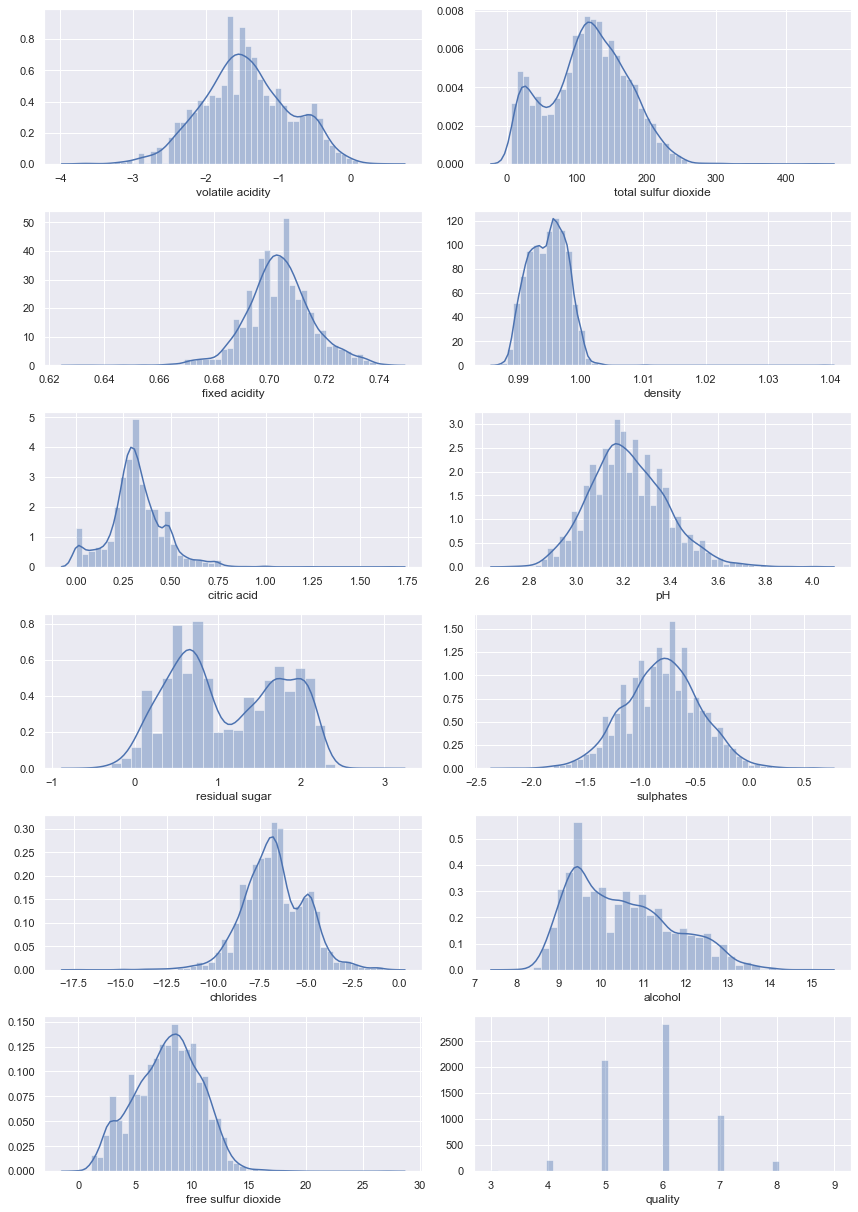

In [73]:
fig, axes = plt.subplots(6, 2, figsize = (12,17))

ax = sns.distplot(wine['volatile acidity'], ax=axes[0, 0])
ax = sns.distplot(wine['fixed acidity'], ax=axes[1, 0])
ax = sns.distplot(wine['citric acid'], ax=axes[2, 0])
ax = sns.distplot(wine['residual sugar'], ax=axes[3, 0])
ax = sns.distplot(wine['chlorides'], ax=axes[4, 0])
ax = sns.distplot(wine['free sulfur dioxide'], ax=axes[5, 0])
ax = sns.distplot(wine['total sulfur dioxide'], ax=axes[0, 1])
ax = sns.distplot(wine['density'], ax=axes[1, 1])
ax = sns.distplot(wine['pH'], ax=axes[2, 1])
ax = sns.distplot(wine['sulphates'], ax=axes[3, 1])
ax = sns.distplot(wine['alcohol'], ax=axes[4, 1])
ax = sns.distplot(wine['quality'], ax=axes[5, 1], kde = False)

plt.tight_layout()

As evident by the graphs it seems a large portion of our attributed are right skewed, we will try to address this issue with a Box-Cox transformation. 

In [74]:
numeric_features = list(wine.dtypes[(wine.dtypes != "str") & (wine.dtypes !='object')].index)
numeric_features.remove('wine_color')

#using scipy.stats.skew to measure skew value
skewed_features = wine[numeric_features].apply(lambda x: skew(x))
skew_values = pd.DataFrame({'skew' :skewed_features})
# Using a skew criteria of 0.7 or -0.7
skew_values = skew_values[np.absolute(skew_values) > 0.7].dropna()
print('There are {} skewed parameters, here are the largest:'.format(len(skew_values.index)))
print(skew_values.sort_values(by = 'skew', ascending = False))

There are 0 skewed parameters, here are the largest:
Empty DataFrame
Columns: [skew]
Index: []


In [75]:
maxlog = {}

#no constant since dealing with right skewed parmaters
for feature in skew_values.index:
    wine[feature], maxlog[feature] = boxcox(wine[feature])

#skewness check after data transform
skew_check = wine[skew_values.index].apply(lambda x: skew(x))
skew_check = pd.DataFrame({'new skew': skew_check})

display(pd.concat([skew_values, skew_check], axis = 1).sort_values(by = 'skew', ascending = False))

,skew,new skew


We were able to bring the largest skewed values closer to a more normal distribution. Lets take a look at the distributions again and analyze the quantile-quantile (qq) plots. The qq plot is a probabiltiy plot that compares two probability distributions through a comparison of their quantiles. 

In [76]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize = (12, 4))
    
    #grabbing mu and sigma after fitting the data to a normal distribution
    (mu, sigma) = norm.fit(data) 
    
    fig1 = fig.add_subplot(1 ,2, 1)
    sns.distplot(data, fit = norm)
    fig1.set_title(measure + ' Distribution (mu = {:.2f}, sigma = {:.2f})'.format(mu, sigma), loc = 'center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    #qq plot
    fig2 = fig.add_subplot(1, 2, 2)
    res = probplot(data, plot = fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f}, kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')
    
    plt.tight_layout()
    

for feature in skew_values.index:
    QQ_plot(wine[feature], str(feature))
    

The kurtosis is a measure of whether the data are heavily-tailed or light_tailed relative to a normal distribution. Data sets with high kurtosis tend to have heavy tails or outliers. Data with low kurtosis tend to have light tails, or a lack of outliers.

It seems that the box cox transformation has presented significant improvements. the distributions pass the QQ plot test since most points in the right graphs seem to be on the line. They have comparable quantiles.

### Identify  and Treat Multicollinearity:
**Multicollinearity** is more troublesome to detect because it emerges when three or more variables, which are highly correlated, are included within a model, leading to unreliable and unstable estimates of regression coefficients. To make matters worst multicollinearity can emerge even when isolated pairs of variables are not collinear.

To identify, we need start with the coefficient of determination, r<sup>2</sup>, is the square of the Pearson correlation coefficient r. The coefficient of determination, with respect to correlation, is the proportion of the variance that is shared by both variables. It gives a measure of the amount of variation that can be explained by the model (the correlation is the model). It is sometimes expressed as a percentage (e.g., 36% instead of 0.36) when we discuss the proportion of variance explained by the correlation. However, you should not write r<sup>2</sup> = 36%, or any other percentage. You should write it as a proportion (e.g., r<sup>2</sup> = 0.36).
![image](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQTS_TVxaBpLmAGthSUAS9w7SVKsmLOtocz7ts-MXioJwa-Se0U)

Already the **Variance Inflation Factor** (**VIF**) is a measure of collinearity among predictor variables within a multiple regression.  It may be calculated for each predictor by doing a linear regression of that predictor on all the other predictors, and then obtaining the R<sup>2</sup> from that regression.  It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variance of a single beta if it were fit alone [1/(1-R<sup>2</sup>)]. Thus, a VIF of 1.8 tells us that the variance (the square of the standard error) of a particular coefficient is 80% larger than it would be if that predictor was completely uncorrelated with all the other predictors. The VIF has a lower bound of 1 but no upper bound. Authorities differ on how high the VIF has to be to constitute a problem (e.g.: 2.50 (R<sup>2</sup> equal to 0.6), sometimes 5 (R<sup>2</sup> equal to .8), or greater than 10 (R<sup>2</sup> equal to 0.9) and so on). 

But there are several situations in which multicollinearity can be safely ignored:

 - ***Interaction terms*** and ***higher-order terms*** (e.g., ***squared*** and ***cubed predictors***) ***are correlated*** with main effect terms because they include the main effects terms. **Oops!** Sometimes we use ***polynomials*** to solve problems, **indeed!** But keep calm, in these cases,  **standardizing** the predictors can **removed the multicollinearity**. 
 - ***Indicator***, like ***dummy*** or ***one-hot-encode***, that represent a ***categorical variable with three or more categories***. If the proportion of cases in the reference category is small, the indicator will necessarily have high VIF's, even if the categorical is not associated with other variables in the regression model. But, you need check if some dummy is collinear or has multicollinearity with other features outside of their dummies.
 - ***Control feature** if the ***feature of interest*** **do not have high VIF's**. Here's the thing about multicollinearity: it's only a problem for the features that are **collinear**. It increases the standard errors of their coefficients, and it may make those coefficients unstable in several ways. But so long as the collinear feature are only used as control feature, and they are not collinear with your feature of interest, there's no problem. The coefficients of the features of interest are not affected, and the performance of the control feature as controls is not impaired.

So, generally, we could run the same model twice, once with severe multicollinearity and once with moderate multicollinearity. This provides a great head-to-head comparison and it reveals the classic effects of multicollinearity. However, when standardizing your predictors doesn't work, you can try other solutions such as:
- removing highly correlated predictors
- linearly combining predictors, such as adding them together
- running entirely different analyses, such as partial least squares regression or principal components analysis

When considering a solution, keep in mind that all remedies have potential drawbacks. If you can live with less precise coefficient estimates, or a model that has a high R-squared but few significant predictors, doing nothing can be the correct decision because it won't impact the fit.

Given the potential for correlation among the predictors, we'll display the variance inflation factors (VIF), which indicate the extent to which multicollinearity is present in a regression analysis. Hence such variables need to be removed from the model. Deleting one variable at a time and then again checking the VIF for the model is the best way to do this.

So, I start the analysis already having removed the features with he highest collinearities and run VIF.

In [77]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

cols = wine.columns.str.replace(' ', '_')
df = wine.copy()
df.columns = cols
cols = list(cols.drop(['wine_color', 'label', 'quality']))

def VRF(predict, data, y):

    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(data), columns = cols)
    features = '+'.join(cols)
    df['label'] = y.values
    
    #grabbing y and X based off regression
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type = 'dataframe')
    
    #Vif factor calculations for each X
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    
    #VIF inspection
    display(vif.sort_values('VIF Factor', ascending = False))
    return vif

vif = VRF('label', df.loc[:, cols], wine['label'])

ModuleNotFoundError: No module named 'patsy'

All the VIF values seem to be at reasonable values so we will leave most of them except for density which seems to be abnormally high. Let's see what that does to out VIF values.

In [ ]:
cols = wine.columns.str.replace(' ', '_')
df = wine.copy()
df.columns = cols

# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['wine_color', 'label', 'quality', 'density']))

vif = VRF('label', df.loc[:, cols], wine['label'])

del df, vif

Getting rid of density seemed to decrease our multicolinearity. 

### Feature Selection into the Pipeline

Since we have a few features it may be enough to only remove collinear and multicollinear. However, although collinearity and multicollinearity levels are low and there are models to handle this. It may still be interesting to proceed with the selection of variables within the pipeline, allowing us to decide if there will be selection of variables and by which method we should proceed with. We can still improve the results through hyper parameterization and cross-validation.

In [ ]:
class select_features(object):
    def __init__(self, select_cols):
        self.select_cols = select_cols
        
    def fit(self, X, y):
        pass
    
    def transform(self, X):
        return X.loc[:, self.select_cols]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        df = self.transform(X)
        return df
    
    def __getitem__(self, x):
        return self.X[x], self.Y[x]

### Dimensionality Reduction

#### PCA (Principal Component Analysis)

PCA is statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principle components. If there are n observations wit p variables, then the number of distinct principle components is `min(n-1,p)`. This transformation is defined in such a way that the first principal component has the largest possible variance, and each suceeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set.

PCA basically reduces the number of variables (dimensionality) of your data trying to minimize the loss of information as you perform this transformation. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

def pca_analysis(df, y_train, feat):
    scale = StandardScaler()
    df = pd.DataFrame(scale.fit_transform(df), index=df.index)
    pca_all = PCA(random_state=101, whiten=True).fit(df)

    my_color=y_train

    # Store results of PCA in a data frame
    result=pd.DataFrame(pca_all.transform(df), columns=['PCA%i' % i for i in range(df.shape[1])], index=df.index)

    # Plot initialisation
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set2_r", s=60,
               edgecolor = 'white')

    # make simple, bare axis lines through space:
    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA on the Wines dataset for " + (feat))
    plt.show()

    X_train , X_test, y, y_test = train_test_split(df , y_train, test_size=0.3, random_state=0)

    KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
    KNC = KNC.fit(X_train, y)
    print('KNeighbors Classifier Training Accuracy: {:2.2%}'.format(accuracy_score(y, KNC.predict(X_train))))
    y_pred = KNC.predict(X_test)
    print('KNeighbors Classifier Test Accuracy: {:2.2%}'.format(accuracy_score(y_test, y_pred)))

    print('_' * 40)
    print('\nAccurance on', feat, ' Prediction By Number of PCA COmponents:\n')
    AccPca = pd.DataFrame(columns=['Components', 'Var_ratio', 'Train_Acc', 'Test_Acc'])

    for componets in np.arange(1, df.shape[1]):
        variance_ratio = sum(pca_all.explained_variance_ratio_[:componets])*100
        pca = PCA(n_components=componets, random_state=101, whiten=True)
        X_train_pca = pca.fit_transform(X_train)
        Components = X_train_pca.shape[1]
        KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
        KNC = KNC.fit(X_train_pca, y)
        Training_Accuracy = accuracy_score(y, KNC.predict(X_train_pca))
        X_test_pca = pca.transform(X_test)
        y_pred = KNC.predict(X_test_pca)
        Test_Accuracy = accuracy_score(y_test, y_pred)
        AccPca = AccPca.append(pd.DataFrame([(Components, variance_ratio, Training_Accuracy, Test_Accuracy)],
                                            columns=['Components', 'Var_ratio', 'Train_Acc', 'Test_Acc']))#], axis=0)

    AccPca.set_index('Components', inplace=True)
    display(AccPca.sort_values(by='Test_Acc', ascending=False))

#running wine color pca analysis
cols = wine.columns
cols = list(cols.drop(['wine_color', 'label', 'quality']))
pca_analysis(wine.loc[:, cols], wine['wine_color'], 'wine_color')

#running wine quality pca analysis
cols = wine.columns
cols = list(cols.drop(['wine_color', 'label', 'quality']))
pca_analysis(wine.loc[:, cols], wine['label'], 'Quality')

It seems that our nearest neighbors model for quality didn't perform nearly as well as the wine color classifier. The second graph seems to indicate that principal components are a bit more tangled than wine color that has a clear clustering. 

#### Linear Discriminant Analysis (LDA)

This form of data science is a very common technique used for supervised classification problems. A Linear Discriminant Analysis is a dimensionality reduction technique that reduces the dimensions by trying to remove redunant and dependent features. LDA can be used as a technique for feature extraction to increase the computational efficiency and decrease over fitting.

**Some Important Parameters:**
solver : string, optional
    Solver to use, possible values:
      - svd: Singular value decomposition (default).
        Does not compute the covariance matrix, therefore this solver is
        recommended for data with a large number of features.
      - eigen: Eigenvalue decomposition, can be combined with shrinkage.

shrinkage : string or float, optional
    Shrinkage parameter, possible values:
      - None: no shrinkage (default).
      - auto: automatic shrinkage using the Ledoit-Wolf lemma.
      - float between 0 and 1: fixed shrinkage parameter.


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def LDA_analysis(df, y_train, feat):
    X_train , X_test, y, y_test = train_test_split(df , y_train, test_size=0.3, random_state=0)

    KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
    KNC = KNC.fit(X_train, y)
    print('KNC Training Accuracy: {:2.2%}'.format(accuracy_score(y, KNC.predict(X_train))))
    y_pred = KNC.predict(X_test)
    print('KNC Test Accuracy: {:2.2%}'.format(accuracy_score(y_test, y_pred)))
    print('_' * 40)
    print('\nApply LDA:\n')
    lda = LDA(n_components=2, store_covariance=True)
    X_train_lda = lda.fit_transform(X_train, y)
    #X_train_lda = pd.DataFrame(X_train_lda)

    print('Number of features after LDA:',X_train_lda.shape[1])
    KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
    KNCr = KNC.fit(X_train_lda, y)
    print('LR Training Accuracy With LDA: {:2.2%}'.format(accuracy_score(y, KNC.predict(X_train_lda))))
    X_test_lda = lda.transform(X_test)
    y_pred = KNC.predict(X_test_lda)
    print('LR Test Accuracy With LDA: {:2.2%}'.format(accuracy_score(y_test, y_pred)))

    if X_train_lda.shape[1]==1:
        fig = plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        plt.scatter(X_train_lda[y==0, 0], np.zeros((len(X_train_lda[y==0, 0]),1)), color='red', alpha=0.1)
        plt.scatter(X_train_lda[y==1, 0], np.zeros((len(X_train_lda[y==1, 0]),1)), color='blue', alpha=0.1)
        plt.title('LDA on Training Data Set')
        plt.xlabel('LDA')
        fig.add_subplot(122)
        plt.scatter(X_test_lda[y_test==0, 0], np.zeros((len(X_test_lda[y_test==0, 0]),1)), color='red', alpha=0.1)
        plt.scatter(X_test_lda[y_test==1, 0], np.zeros((len(X_test_lda[y_test==1, 0]),1)), color='blue', alpha=0.1)
        plt.title('LDA on Test Data Set')
        plt.xlabel('LDA')
    else:
        fig = plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        plt.scatter(X_train_lda[y==0, 0], X_train_lda[y==0, 1], color='black', alpha=0.1)
        plt.scatter(X_train_lda[y==1, 0], X_train_lda[y==1, 1], color='yellow', alpha=0.1)
        plt.scatter(X_train_lda[y==2, 0], X_train_lda[y==2, 1], color='red', alpha=0.1)
        plt.title('LDA on Training Data Set')
        plt.xlabel('LDA')
        fig.add_subplot(122)
        plt.scatter(X_test_lda[y_test==0, 0], X_test_lda[y_test==0, 1], color='black', alpha=0.1)
        plt.scatter(X_test_lda[y_test==1, 0], X_test_lda[y_test==1, 1], color='yellow', alpha=0.1)
        plt.scatter(X_test_lda[y_test==2, 0], X_test_lda[y_test==2, 1], color='red', alpha=0.1)
        plt.title('LDA on Test Data Set')
        plt.xlabel('LDA')

    plt.show()
    
cols = wine.columns
cols = list(cols.drop(['wine_color', 'label', 'quality']))
LDA_analysis(wine.loc[:, cols], wine['wine_color'], 'Type')

cols = wine.columns
cols = list(cols.drop(['wine_color', 'label', 'quality']))
LDA_analysis(wine.loc[:, cols], wine['label'], 'Quality')

We see a similar issue when examining the accuracy between the wine color model and the quality label model. This is just testing accuracy so it may be beneficial checking F1, precision, and recall. However, the graphs look good for LDA and PCA analysis. 

## Modeling
We start to looking at different approaches to implement classifiers models, and use hyper parametrization, cross validation and compare the results between different errors measures.

First we will make some support functions help us evaluate ours models through a standard. Next, we proceed with the classifications of wines types and next of wines quality labels. We will finalize our quality classification model with a staking approach.

### Evaluating Results
We will be using a confusion matrix, classification report, F1 score, recall, precision and ROC AUC to examine our models results. Here is a description of our evaluation metrics: 
- The model main performance metrics Accuracy, Precision, Recall and F1 Score
- The prediction confusion matrix
- The ROC AUC Score
- Features importance plot

The reciever operating curve (ROC curve) is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. This is created by plotting the true positive rate against the false positive rate



### Hyper Parametrization
Hyperparameters are also known as meta-parameters and are usually set before we start the model training process. These hyperparameters do not have any dependency on being derived from the underlying data on which the model is trained. Usually these hyperparameters represent some high level concepts or knobs, which can be used to tweak and tune the model during training to improve its performance. 

So, let's start with the wine type classifier models.

### Wine Type Classifier Models:
We will start with trying to classify the wines by red or white. 

Let's prepare our data with focus on type of wines and make the split of training and test datasets to use in the following tasks.

In [ ]:
cols = wine.columns
cols = list(cols.drop(['wine_color','label']))
y = wine['wine_color']
X_train, X_test, y_train, y_test = train_test_split(wine.loc[:, cols], y, test_size=0.3, random_state = 77)

#### Logistic Regression
Since it is a binary classification task, we try first with a simple logistic regression.

This class implements regularized [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) using the 'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle both dense and sparse input. 

**Main Parameters**
 - class_weight : dict or 'balanced', default: None
   The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as ``n_samples / (n_classes * np.bincount(y))``.

   For how class_weight works: It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1. So higher class-weight means you want to put more emphasis on a class. For example, our class 0 is 1.24 times more frequent than class 1. So you should increase the class_weight of class 1 relative to class 0, say {1: 0.6, 0: 0.4}. If the class_weight doesn't sum to 1, it will basically change the regularization parameter.

   "balanced" basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.
   

 - warm_start : bool, default: False. Useless for liblinear solver.
 - ``'clf__multi_class' : ['ovr', 'multinomial']`` for ``'clf__solver': ['newton-cg', 'sag', 'lbfgs']``

**Attributes:**
 - coef_ : array, shape (1, n_features) or (n_classes, n_features)
 - intercept_ : array, shape (1,) or (n_classes,)
 - n_iter_ : array, shape (n_classes,) or (1, )

**See also:**
 - SGDClassifier : incrementally trained logistic regression (when given the parameter ``loss="log"``).
 - sklearn.svm.LinearSVC : learns SVM models using the same algorithm.
 
 See our the best results below with first model from a pipeline with grid search CV.

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = Pipeline([
    ('pca', PCA(random_state = 77)),
    ('clf', LogisticRegression(random_state = 77))])


In [ ]:
#dictionary of parameters to tune
n_components = [10, 12]
whiten = [True]
C = [0.003, 0.009, 0.01, 0.1]
tol = [0.001, 0.0001, 0.01]

param_grid =\
    [{'clf__C': C
     ,'clf__solver': ['liblinear', 'saga'] 
     ,'clf__penalty': ['l1', 'l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced']
     ,'pca__n_components' : n_components
     ,'pca__whiten' : whiten
},
    {'clf__C': C
     ,'clf__max_iter': [3, 9, 2, 7, 4]
     ,'clf__solver': ['newton-cg', 'sag', 'lbfgs']
     ,'clf__penalty': ['l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced'] 
     ,'pca__n_components' : n_components
     ,'pca__whiten' : whiten
}]

#Grid search allows us to figure out the best model given some varying parameters
gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'accuracy', cv = 5, verbose = 1, n_jobs = -1)
LR = Pipeline([
        #('sel', select_fetaures(select_cols=list(shadow))),
        ('scl', StandardScaler()),
        #('lda', LDA(store_covariance=True)),
        ('gs', gs)]) 

LR.fit(X_train,y_train)
results = get_results(LR, 'LogisticRegression', X_test, y_test, reasume=True)

In [4]:
confusion = confusion_matrix(y_test, predictions)
ticklabels = ['False', 'True']
ax = sns.heatmap(confusion, annot = True, cbar = False, fmt = 'g', 
                 yticklabels = ticklabels, xticklabels = ticklabels,
                 cmap = 'Blues')

print(classification_report(y_test, predictions))

auc_score = auc(roc_curve(y_test, predictions)[0],roc_curve(y_test, predictions)[1])
print('AUC score: {}'.format(auc_score))

NameError: name 'confusion_matrix' is not defined

This did wonderful in all metrics performance.

These results are really sufficient and obtained through a very simple model, but out of curiosity, we will submit the same data to a Deep Neural Network Classifier.

#### Deep Neural Network

The most simple neural network is the "perceptron", which, in its simplest form, consists of a single neuron. The perceptrons only work with numerical data, so, you should convert any nominal data into a numerical format.

The the perceptron has a important limitation, it could only represent linear separations between classes. To overcome this we can use the multi-layer perceptron overcomes that can be represent more complex decision boundaries.

Multi-layer perceptrons are also known as "feed-forward neural networks". These are more complex networks as they consist of multiple neurons that are organized in layers. The number of layers is usually limited to two or three, but theoretically, there is no limit!

Among the layers, you can distinguish an input layer, hidden layers and an output layer. Multi-layer perceptrons are often fully connected. This means that there's a connection from each perceptron in a certain layer to each perceptron in the next layer. Even though the connectedness is no requirement, this is typically the case.

One of the most powerful and easy-to-use Python libraries for developing and evaluating deep learning models is [Keras](https://keras.io/models/sequential/). It wraps the efficient numerical computation libraries Theano and TensorFlow. The advantage of this is mainly that you can get started with neural networks in an easy and fun way. A quick way to get started is to use the Keras Sequential model: it's a linear stack of layers. You can easily create the model by passing a list of layer instances to the constructor, which you set up by running `model = Sequential()`.

So, let's go and create our DNN classifier of type wines in  Keras with TensorFlow:

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

wtp_dnn_model = Sequential()
wtp_dnn_model.add(Dense(64, activation = 'relu', input_shape = (12,)))
wtp_dnn_model.add(Dropout(rate = 0.3))
wtp_dnn_model.add(Dense(32, activation = 'relu'))
wtp_dnn_model.add(Dense(16, activation = 'relu'))
wtp_dnn_model.add(Dense(1, activation = 'sigmoid'))

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

wtp_dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = wtp_dnn_model.fit(X_train, y_train, epochs=45, batch_size=50, 
                            shuffle=True, validation_split=0.2, verbose=1, 
                            callbacks = [early_stop])

wtp_dnn_ypred = wtp_dnn_model.predict_classes(X_test)

NameError: name 'StandardScaler' is not defined

In [2]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = np.arange(1, len(history.history['accuracy']) + 1)
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

plt.tight_layout()

NameError: name 'plt' is not defined

From the accuracy and loss plot, you can note that the early stopped the learning process at the 43<sup>rd</sup> epoch, this seems to me an accurate stop and if continued may cause overfitting.

Let's check the report.

In [5]:
confusion = confusion_matrix(y_test, wtp_dnn_ypred)
ticklabels = ['False', 'True']
ax = sns.heatmap(confusion, annot = True, cbar = False, fmt = 'g', 
                 yticklabels = ticklabels, xticklabels = ticklabels,
                 cmap = 'Blues')

print(classification_report(y_test, wtp_dnn_ypred))

auc_score = auc(roc_curve(y_test, wtp_dnn_ypred)[0], roc_curve(y_test, wtp_dnn_ypred)[1])
print('AUC score: {}'.format(auc_score))

NameError: name 'confusion_matrix' is not defined

As you can see, we got incredible results from each evaluation, the dense neural network seems to be performing a bit better. The results confirms that DNN is marginally better.

### Wine Quality Classifier Models:
Now, let's move on to modeling a wine quality classifier. For this, let's prepare our dataset to focus on our wine quality label feature.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(wine.drop(['label', 'quality'], axis = 1), wine['label'], test_size=0.30, random_state=77)

NameError: name 'train_test_split' is not defined

#### Decision Tree Classifier

[Decision Trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

___Some advantages of decision trees are:___

- Simple to understand and to interpret. Trees can be visualised.
- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. See algorithms for more information.
- Able to handle multi-output problems.
- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

___The disadvantages of decision trees include:___

- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf = Pipeline([('clf', DecisionTreeClassifier(random_state = 77))])

# parameter dictionary for tuning
criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9 ,10, 11, 15]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None]

param_grid =\
    [{ 'clf__class_weight': class_weight
      ,'clf__criterion': criterion
      ,'clf__splitter': splitter
      ,'clf__max_depth': max_depth
      ,'clf__min_samples_leaf': min_samples_leaf
}]

gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'accuracy',
                  cv = 5, verbose = 1, n_jobs = -1)

DT = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

DT.fit(X_train, y_train)
DT_predictions = DT.predict(X_test)

NameError: name 'Pipeline' is not defined

In [8]:
print(classification_report(y_test, DT_predictions))
confusion = confusion_matrix(y_test, DT_predictions)
ticklabels = ['1: Bad', '   2: Average', '   3: High']
ax = sns.heatmap(confusion, annot = True, cbar = False, fmt = 'g', 
                 yticklabels = ticklabels, xticklabels = ticklabels,
                 cmap = 'OrRd', linecolor = 'black', linewidth = 1)
ax.set_xlabel('True/Actual')
ax.set_ylabel('Predicted')

#'ovo' multiclass for the average of all possible pairwise combinations, insensitive to class imbalance
auc_score = roc_auc_score(y_test, DT.predict_proba(X_test), multi_class = 'ovo', average = 'weighted')
print('AUC score: {}'.format(auc_score))

NameError: name 'classification_report' is not defined

As you can see, our results aren't nearly as nice as our wine type classification results. This is most likely a result of data imbalances since high quality wines seem to be ocntinuously misclassified as either medium or low quality. This is expected since we lack training samples for high quality wine. If we run the model and set class_weight to balanced, we will able to raise the recall and f1-score of the high class, but we will most likely have significant loss in other performance metrics. 

The main advantage of decision tree based models is model interpretability, since it is quite easy to understand and interpret the decision rules which led to a specific model prediction. Trees can be even visualized to understand and interpret decision rules better. For better understand, I rerun the decision tree with the same parameters, but without scaling the features and include the following code helps us visualize decision trees: